# Double backward with custom functions
**Custom Function有两种方式影响grad mode**：
1. 在forward pass执行过程中，autograd不会在Graph上记录其中执行的ops。forward pass结束后，自定义函数的backward methods会被记录为forward ops的各个outputs的grad_fn
2. backward过程中，如果<font color=blue>**create_graph=True**</font>，autograd会记录下用来计算backward pass的computation graph

**save_for_backward如何与上述机制协作**：如果autograd能记录backward中执行的computations，则函数自动支持double backward。

理解：<font color=green>double backward本质上就是对backward中的computation再做一次backward。</font>所以，只要backward method的inputs中有tenosr是requires_grad=True的，那么backward中的计算就能被autograd记录。

## I. saved_tensor是inputs
1. 如果<font color=green>**input tensor的requires_grad=True**</font>，且input tensor是saved_tensor，也就是backward method的input。在autograd的规则下，backward method的input tensor中至少有1个的requires_grad=True，因此backward method的output.grad_fn会指向backward computation的backward method，也就是二阶backward method。
2. 通过上述方式，autograd可以自动完成二阶梯度的计算。此时，torch.autograd.grad实际上被视为普通的function，它执行的computation对应的backward method也被记录到graph上。
3. 如果要用torchviz显示graph，要在torch.autograd.grad中设置<font color=green>**create_graph=True**</font>。否则运行grad之后，graph就会被释放掉。

In [1]:
## 例1：机制示例  

import torch
import torchviz

class Square(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x**2

    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        return grad_out * 2 * x

# finite differencing method会放大error，所以用双精度
x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)

print(torch.autograd.gradcheck(Square.apply, x))

# 用gradcheck来验证second-order derivatives
print(torch.autograd.gradgradcheck(Square.apply, x))

True
True


#### 1.用torch.autograd.grad呈现double backward的Graph
此时graph上有backward computation对应的backward method(double backward)的Node。如：下例中Mulbackward0。\
· square运算的backward method中唯一的computation是multiple。 \
· 所以double backward就是backward of multiple function。

tensor(2., grad_fn=<MulBackward0>)


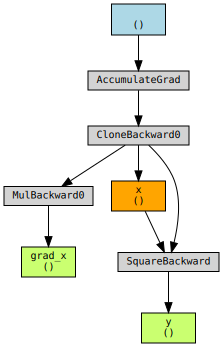

In [2]:
x = torch.tensor(1., requires_grad=True).clone()
y = Square.apply(x)

# 这里要设create_graph=True，否则后面torchviz画图会报错：
# RuntimeError: Trying to backward through the graph a second time
# (or directly access saved tensors after they have already been freed).
grad_x, = torch.autograd.grad(y, x, create_graph=True) 
print(grad_x)

# 完整的graph
torchviz.make_dot((grad_x, x, y), {'grad_x':grad_x, 'x':x, 'y':y})
# 简化：不画x作为output的那部分
# torchviz.make_dot((grad_x, y), {'grad_x':grad_x, 'x':x, 'y':y})

tensor(2., grad_fn=<MulBackward0>)


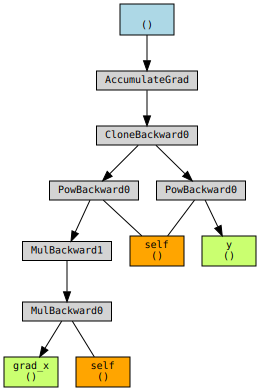

In [3]:
## 对比：用pytorch自带的square函数
#  (1)自带的'**'运算用tensor.pow()实现，所以backward是PowBackward
#  (2)grad_x为什么有那么多？估计是和torch.pow()的backward method的实现方式有关
#  (3)PowBackward0没有显示x作为input，估计是因为自带的power函数的pack/unpack机制差异

x2 = torch.tensor(1., requires_grad=True).clone()
y2 = torch.pow(x2, 2)
grad_x2, = torch.autograd.grad(y2, x2, create_graph=True) 
print(grad_x2)

# 完整图
torchviz.make_dot((grad_x2, x2, y2), {'grad_x':grad_x2, 'x':x2, 'y':y2},show_saved=True)
# 简化：不画x作为output的那部分
# torchviz.make_dot((grad_x2, y2), {'grad_x':grad_x2, 'x':x2, 'y':y2}, show_saved=True)

#### 2. 用autograd.backward则graph上没有backward computation对应的Node
因为backward没有output，因此没有output.grad_fn指向backward method。所以autograd就不会为该运算在graph上生成对应的Node

/home/roark/anaconda3/envs/231n/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


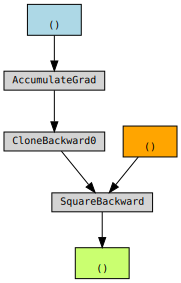

In [4]:
x = torch.tensor(1., requires_grad=True).clone()
y = Square.apply(x)
y.backward(create_graph=True)

# 完整图
# torchviz.make_dot((y, x))
torchviz.make_dot(y)

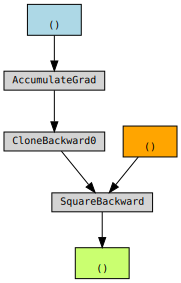

In [5]:
## 扩展样例1：与backward相似的情景
#  函数没有output，所以在graph上没有记录

temp = []
def no_return_foo(x):
    temp.append(x)

x = torch.tensor(1., requires_grad=True).clone()
y = Square.apply(x)
no_return_foo(x)
# y.backward(create_graph=True)

# 完整图
# torchviz.make_dot((y, x))
torchviz.make_dot(y)

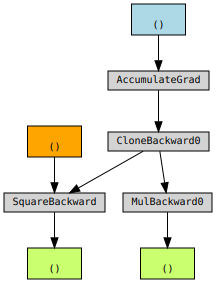

In [6]:
## 扩展样例2：与grad相似的情景
#  函数有output，所以在graph上有记录

x = torch.tensor(1., requires_grad=True).clone()
y = Square.apply(x)
z = x * 2

# 完整图
# torchviz.make_dot((y, x, z))
torchviz.make_dot((y, z))

#### 3. 扩展：backward中也有自定义的saved tensor

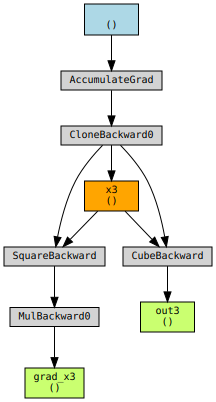

In [7]:
class Cube(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x**3
    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        # 下面不用Square，直接用x**2的话，saved_tensor不会在图中显示
        return grad_out * 3 * Square.apply(x) 

x3 = torch.tensor(1., requires_grad=True).clone()
out3 = Cube.apply(x3)
grad_x3, = torch.autograd.grad(out3, x3, create_graph=True)

# 完整图
torchviz.make_dot((grad_x3, x3, out3), {"grad_x3": grad_x3, "x3": x3, "out3": out3})
# torchviz.make_dot((grad_x3, out3), {"grad_x3": grad_x3, "x3": x3, "out3": out3})

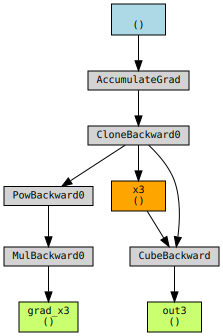

In [8]:
class Cube(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x**3
    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        # 直接用x**2
        return grad_out * 3 * x ** 2
x3 = torch.tensor(1., requires_grad=True).clone()
out3 = Cube.apply(x3)
grad_x3, = torch.autograd.grad(out3, x3, create_graph=True)

# 完整图
torchviz.make_dot((grad_x3, x3, out3), {"grad_x3": grad_x3, "x3": x3, "out3": out3})
# torchviz.make_dot((grad_x3, out3), {"grad_x3": grad_x3, "x3": x3, "out3": out3})

#### 4.注意这里input x做了clone
这可以避免x在其他in-place运算中改变自身的value而改变saved_tensor的value。
下图比较了不用clone时的graph

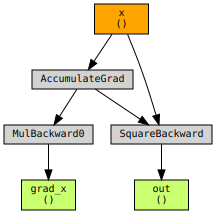

In [9]:
x = torch.tensor(1., requires_grad=True)
out = Square.apply(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, out), {"grad_x": grad_x, "x": x, "out": out})

## II. saved_tensor是outputs
处理机制和前面saved_tensor是inputs相似。
1. 如果function至少有1个<font color=green>**input tensor的requires_grad=True**</font>，那么它的output会自动标记<font color=green>**input tensor的requires_grad=True**</font>。
2. 此时output是backward method的input。在autograd的规则下，backward method的input tensor中至少有1个的requires_grad=True，因此backward method的output.grad_fn会指向backward computation的backward method，也就是二阶backward method。
3. 通过上述方式，autograd可以自动完成二阶梯度的计算。此时，torch.autograd.grad实际上被视为普通的function，它执行的computation对应的backward method也被记录到graph上。
4. 如果要用torchviz显示graph，要在torch.autograd.grad中设置<font color=green>**create_graph=True**</font>。否则运行grad之后，graph就会被释放掉。

#### 1.用torch.autograd.grad呈现double backward的Graph

In [10]:
class Exp(torch.autograd.Function):
    # Simple case where everything goes well
    @staticmethod
    def forward(ctx, x):
        # This time we save the output
        result = torch.exp(x)
        # Note that we should use `save_for_backward` here when
        # the tensor saved is an ouptut (or an input).
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, grad_out):
        result, = ctx.saved_tensors
        return result * grad_out

x = torch.tensor(1., requires_grad=True, dtype=torch.double).clone()
# Validate our gradients using gradcheck
torch.autograd.gradcheck(Exp.apply, x)
torch.autograd.gradgradcheck(Exp.apply, x)

True

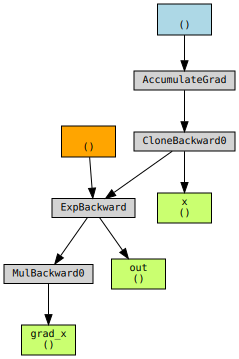

In [11]:
out = Exp.apply(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out})

#### 2.用pytorch原生exp函数做对比
差异不大，主要差异在于multiple运算的saved_tensor方式不同

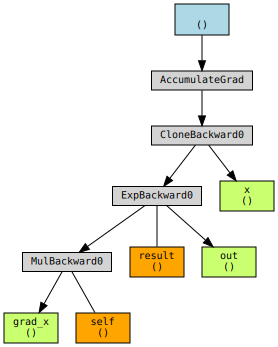

In [12]:
out = torch.exp(x)
grad_x, = torch.autograd.grad(out, x, create_graph=True)
torchviz.make_dot((grad_x, x, out), {"grad_x": grad_x, "x": x, "out": out}, show_saved=True)

## III. saved_tensor是Intermediate results
这种情况比前面两种都复杂。<font color=red>**如果要保存forward computation的中间结果传给backward使用。就得将intermediate tensor作为forward method的outputs。**</font> \
此时，setup_context的argument中output是所有forward method的outputs构成的tuple。由于intermediate tensor是forward的output，他们会被autograd自动加上requires_grad=True。<font color=blue>相当于转化成了前面第二种情况，saved_tensor是forward的output。</font>


这也就意味着，如果想要梯度flow through这些中间值tensor，就要给他们定义梯度计算公式。

例如：implement sinh(x)函数 \
$sinh(x) = \frac{e^x-e^{-x}}{2}$  \
$\frac{dsinh(x)}{dx} = cosh(x) = \frac{e^x+e^{-x}}{2}$ \
从公式上可见，应该为backward的计算保留forward中的$e^x$和$e^{-x}$

In [13]:
class Sinh(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        expx = torch.exp(x)
        expnegx = torch.exp(-x)
        ctx.save_for_backward(expx, expnegx)
        # In order to be able to save the intermediate results, a trick is to
        # include them as our outputs, so that the backward graph is constructed
        return (expx - expnegx) / 2, expx, expnegx

    # 注：backward的input tensor数量要和forward中的output tensor相同
    # _grad_out_exp和_grad_out_negexp分别对应的是expx和expnegx从上游拿到的grad_out
    # 在直接求backward时他们的值都是0，在求double backward时他们有具体值
    @staticmethod
    def backward(ctx, grad_out, _grad_out_exp, _grad_out_negexp):
        expx, expnegx = ctx.saved_tensors
        grad_input = grad_out * (expx + expnegx) / 2
        # 下面两个累积运算是在高阶导数中需要用的，所以不能少
        # 直接求导并不需要，但有也不会影响，因为此时_grad_out_exp和_grad_out_negexp都是0
        grad_input += _grad_out_exp * expx
        grad_input -= _grad_out_negexp * expnegx
        return grad_input

# 要额外构建一个wrapper，让函数只返回第一个output
def sinh(x):
    return Sinh.apply(x)[0]

x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(sinh, x)
torch.autograd.gradgradcheck(sinh, x)

True

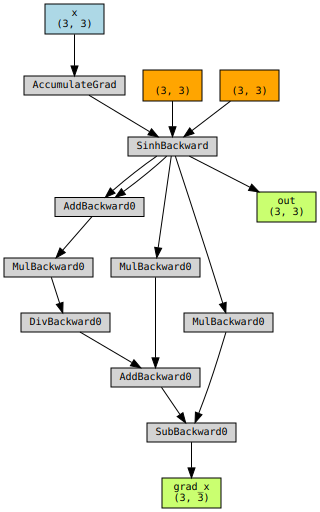

In [14]:
out = sinh(x)
grad_x, = torch.autograd.grad(out.sum(), x, create_graph=True)

torchviz.make_dot((grad_x, x, out), params={"grad_x": grad_x, "x": x, "out": out})